In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import pandas as pd
from scipy import stats
import re
mpl.rcParams['pdf.fonttype'] = 42
#set high res in notebook for retina displays
# %config InlineBackend.figure_format = 'retina'

def read_data(path,index_col=0):
    """Determine the filetype and open as dataframe"""
    if path.endswith('.csv'):
        return pd.read_csv(path,index_col=index_col)
    elif path.endswith('.xls') or path.endswith('.xlsx'):
        return pd.read_excel(path,index_col=index_col)
    else:
        raise ValueError('Filetype not supported')


In [17]:
df = read_data(r'output/SEN06AB-ALB_ELISA results.xlsx', index_col=0)
# df=df[df['within_range']==True]


In [20]:
def statistical_test(dataframe, value_column, group_column, alpha=0.05):
    unique_groups = dataframe[group_column].unique()
    
    if len(unique_groups) == 2:
        print("Only two groups detected. Performing Student's t-test.")
        
        group1_data = dataframe[dataframe[group_column] == unique_groups[0]][value_column]
        group2_data = dataframe[dataframe[group_column] == unique_groups[1]][value_column]
        
        t_stat, p_value_ttest = stats.ttest_ind(group1_data, group2_data)
        print(f"Student's t-test p-value: {p_value_ttest}")
        return None if p_value_ttest >= alpha else p_value_ttest
    
    else:
        print("Multiple groups detected. Performing one-way ANOVA followed by Tukey HSD.")
        
        # Perform one-way ANOVA
        model = ols(f'{value_column} ~ C({group_column})', data=dataframe).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        p_value_anova = anova_table.loc['C({})'.format(group_column), 'PR(>F)']
        
        print(f"One-way ANOVA p-value: {p_value_anova}")
        
        if p_value_anova < alpha:
            # Perform Tukey HSD
            tukey = pairwise_tukeyhsd(endog=dataframe[value_column], groups=dataframe[group_column], alpha=alpha)
            summary = tukey.summary()
            tukey_df = pd.DataFrame(summary[1:], columns=summary[0])
            tukey_df.columns = tukey_df.columns.astype(str)
            tukey_df = tukey_df.applymap(lambda x: x.data if isinstance(x, sm.iolib.table.Cell) else x)
            tukey_df['reject'] = tukey_df['reject'].astype(bool)
            return tukey_df
        else:
            print("ANOVA test did not find statistically significant differences. Skipping Tukey HSD test.")
            return None

# Use the function
result = statistical_test(df, 'ug_1e6_24h', 'name')
pairs = result[result.group1=='Control']
p_values = [i[1]["p-adj"] for i in pairs.iterrows()]
pairs = list(zip(pairs.group1, pairs.group2))
df= df[:30]


Multiple groups detected. Performing one-way ANOVA followed by Tukey HSD.
One-way ANOVA p-value: 3.8347816349572256e-17


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Doxorubicin 0.2uM: Custom statistical test, P_val:8.385e-01
Control vs. Palbociclib 1.5um: Custom statistical test, P_val:0.000e+00
Control vs. Palbociclib 2um: Custom statistical test, P_val:0.000e+00
Control vs. Doxorubicin 0.5uM: Custom statistical test, P_val:0.000e+00


C:\Users\adams\AppData\Local\Temp\ipykernel_7784\1570821036.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size_labels)
c:\Users\adams\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\adams\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


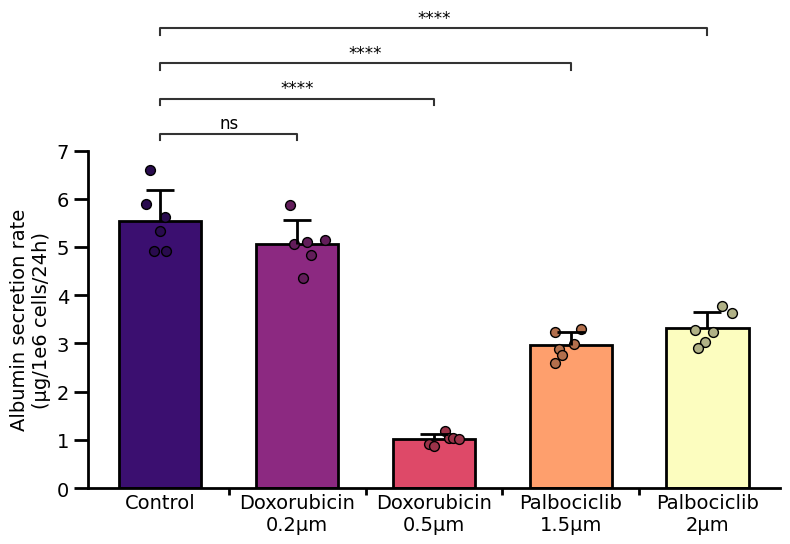

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import re
from statannotations.Annotator import Annotator

def nice_barplots(df, pairs, p_values,ylabel,xlabel):
    values_col = ylabel
    group_col = 'name'
    line_width = 2
    font_size_labels = 14
    fig_size = (8, 6)

    grouped = df.groupby(group_col).agg({'ug_1e6_24h': ['mean', 'std']})
    means = grouped['ug_1e6_24h', 'mean'].values
    errors = grouped['ug_1e6_24h', 'std'].values

    names = grouped.index.to_list()
    formatted_names = [x.replace(' ','\n') for x in names]
    formatted_names =[re.sub('um','μm',x,flags=re.IGNORECASE) for x in formatted_names]
    barWidth = 0.6
    positions = np.arange(len(names))

    magma_colours = plt.get_cmap('magma')
    colours = [magma_colours(i) for i in np.linspace(0.2, 1, len(names))]
    scatter_colours = [(r*0.7, g*0.7, b*0.7) for r, g, b, _ in colours]

    fig, ax = plt.subplots(figsize=fig_size)
    
    def add_jitter(values, width=0.075):
        jitter = np.random.randn(len(values)) * width
        return values + jitter

    for idx, name in enumerate(names):
        values = df[df[group_col] == name]['ug_1e6_24h'].values
        ax.scatter(add_jitter([positions[idx]] * len(values)), values, color=scatter_colours[idx], s=50, zorder=3,linewidth=1, edgecolor=(0,0,0,0.5), alpha=1)
    
    bars = ax.bar(positions, means, color=colours, width=barWidth, edgecolor='black', linewidth=line_width)
    for idx, (y, yerr) in enumerate(zip(means, errors)):
        (_,caplines,__) = ax.errorbar(positions[idx], y, yerr=yerr, elinewidth=line_width, markeredgewidth=line_width, capsize=5, lolims=True, ls='None', color='black',zorder=3)
        caplines[0].set_marker('_')
        caplines[0].set_markersize(20)
        caplines[1].set_marker('')

    ax.tick_params(axis='both', which='major', width=line_width, length=10)
    ax.set_ylabel(values_col, fontsize=font_size_labels)
    ax.set_xticks(positions)
    ax.set_xticklabels(formatted_names, fontsize=font_size_labels)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size_labels)
    ax.set_xticks(positions)
    ax.set_xticks([pos + 0.5 for pos in positions[:-1]], minor=True)
    ax.tick_params(axis='x', which='major', length=0)
    ax.tick_params(axis='x', which='minor', bottom=True, length=5, width=line_width)
    ax.set_ylim(0, np.ceil(df['ug_1e6_24h'].max()))
    annotator = Annotator(ax, pairs, data=df, x=group_col, y='ug_1e6_24h')
    annotator.configure(test=None, text_format='star', loc='outside', fontsize=font_size_labels-2)
    annotator.set_pvalues_and_annotate(p_values)

    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['bottom','left']:
        ax.spines[line].set_linewidth(line_width)



    plt.tight_layout()
    plt.show()
    plt.savefig(r'output\SEN06_ALB_ELISA.pdf')

# Example usage
# plot_bar_with_error_and_jitter(df, pairs, p_values)
nice_barplots(df=df, pairs=pairs, p_values=p_values,ylabel='Albumin secretion rate\n(μg/1e6 cells/24h)',xlabel=None)


dict_keys(['Control', 'Doxorubicin 0.2uM', 'Doxorubicin 0.5uM', 'Palbociclib 1.5um', 'Palbociclib 2um'])
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Doxorubicin 0.2uM: Custom statistical test, P_val:8.181e-01
Control vs. Palbociclib 1.5um: Custom statistical test, P_val:1.000e-03


<ipython-input-6-b2620308cea1>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size_labels)


Control vs. Palbociclib 2um: Custom statistical test, P_val:1.000e-03
Control vs. Doxorubicin 0.5uM: Custom statistical test, P_val:1.000e-03


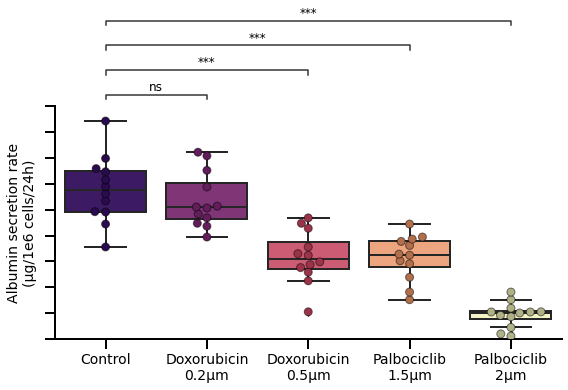

<Figure size 432x288 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from statannotations.Annotator import Annotator

def adaptive_ceil(value):
    if value == 0:
        return 0
    magnitude = 10 ** (np.floor(np.log10(abs(value))))
    return np.ceil(value / magnitude) * magnitude

def nice_boxplots(df, x,y, pairs, p_values, ylabel, xlabel):
    values_col = ylabel
    line_width = 2
    font_size_labels = 14
    fig_size = (8, 6)

    grouped = df.groupby(x)
    names = grouped.groups.keys()
    print(names)
    formatted_names = [str(x).replace(' ','\n') for x in names]
    formatted_names =[re.sub('um','μm',x,flags=re.IGNORECASE) for x in formatted_names]
    
    magma_colours = plt.get_cmap('magma')
    colours = [magma_colours(i) for i in np.linspace(0.2, 1, len(names))]
    scatter_colours = [(r*0.7, g*0.7, b*0.7) for r, g, b, _ in colours]
    fig, ax = plt.subplots(figsize=fig_size)
    
    sns.boxplot(x=x, y=y, data=df, ax=ax, palette=colours, linewidth=line_width)
    sns.swarmplot(x=x, y=y, data=df, ax=ax, size=8, palette=scatter_colours, linewidth=1, edgecolor=(0,0,0,0.5))
    

    ax.set_ylim(0, adaptive_ceil(df[y].max()))
    ax.tick_params(axis='both', which='major', width=line_width, length=10)
    ax.set_ylabel(values_col, fontsize=font_size_labels)
    ax.set_xticks(np.arange(len(formatted_names)))
    ax.set_xticklabels(formatted_names, fontsize=font_size_labels)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size_labels)
    ax.set_xlabel(xlabel, fontsize=font_size_labels)
    annotator = Annotator(ax, pairs, data=df, x=x, y=y)
    annotator.configure(test=None, text_format='star', loc='outside', fontsize=font_size_labels-2)
    annotator.set_pvalues_and_annotate(p_values)

    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['bottom','left']:
        ax.spines[line].set_linewidth(line_width)

    plt.tight_layout()
    plt.show()
    plt.savefig(r'output\SEN06_ALB_ELISA.pdf')

# Example usage
# plot_box_with_jitter(df, pairs, p_values)
nice_boxplots(df=df,x='name',y='ug_1e6_24h', pairs=pairs, p_values=p_values, ylabel='Albumin secretion rate\n(μg/1e6 cells/24h)', xlabel=None)




In [ ]:
anotherdf = pd.read_csv(r'combined_data_analysed.csv',index_col=0)
anotherdf




In [ ]:
pairs = [(0,24),(0,48),(0,72),(24,48),(24,72),(48,72)]
for ch in anotherdf.Channel.unique():
    print(ch)
    df1 = anotherdf[anotherdf.Channel==ch]
    result = statistical_test(df1, 'Area', 'Timepoint')
    result = result if result is not None else pd.DataFrame()
    if not result.empty:
        p_values = [i[1]["p-adj"] for i in result.iterrows()]
        pairs = [(0,24),(0,48),(0,72),(24,48),(24,72),(48,72)]
        nice_boxplots(df=df1,x='Timepoint',y='Area', pairs=pairs, p_values=p_values, ylabel='Staining area (AU)', xlabel='Timepoint (h)')

# result = statistical_test(df, 'Area', 'Timepoint')
# p_values = [i[1]["p-adj"] for i in pairs.iterrows()]
# 
# nice_boxplots(df=df,x='Timepoint',y='Area', pairs=pairs, p_values=p_values, ylabel='Albumin secretion rate\n(μg/1e6 cells/24h)', xlabel=None)
